In [1]:
import math
import numpy as np
import os
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Reshape, BatchNormalization, UpSampling2D, Conv2D, LeakyReLU
from tensorflow.keras.layers import Flatten, Dropout
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

import zipfile

In [2]:
with zipfile.ZipFile("../input/generative-dog-images/all-dogs.zip","r") as zip_ref:
    zip_ref.extractall("/kaggle/temp/")
    
with zipfile.ZipFile("../input/generative-dog-images/Annotation.zip","r") as zip_ref:
    zip_ref.extractall("/kaggle/temp/")

In [3]:
img_list =os.listdir("/kaggle/temp/all-dogs")
len(img_list)

20579

In [4]:
len(img_list)

20579

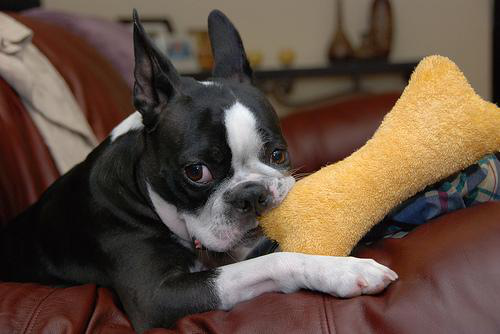

In [5]:
# visualize one training sample
temp_img = load_img("/kaggle/temp/all-dogs/"+img_list[10000])
temp_img

In [6]:
temp_img_array = img_to_array(temp_img)
temp_img_array.shape

(334, 500, 3)

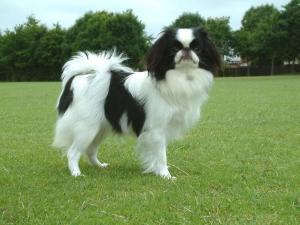

In [7]:
# visualize one training sample
temp_img = load_img("/kaggle/temp/all-dogs/"+img_list[1000])
temp_img

In [8]:
temp_img_array = img_to_array(temp_img)
temp_img_array.shape

(225, 300, 3)

In [9]:
# generator model
def generator_model():
    model = Sequential()
    model.add(Dense(input_dim=100, units=1024))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dense(32 * 32 * 128))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Reshape((32, 32, 128), input_shape=(32 * 32 * 128,)))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (5, 5), padding="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(3, (5, 5), padding="same"))
    model.add(Activation("relu"))
    return model

In [10]:
# discriminator model
def discriminator_model():
    model = Sequential()
    model.add(Conv2D(64, (5,5), strides=(2, 2), input_shape=(128, 128, 3), padding="same"))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(128, (5,5), strides=(2, 2)))
    model.add(LeakyReLU(0.2))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model

In [11]:
# prepare input images
X_train = []
for img in img_list:
    img = img_to_array(load_img("/kaggle/temp/all-dogs/"+img, target_size=(128,128,3)))
    img = (img.astype(np.float32) - 127.5)/127.5
    X_train.append(img)
X_train = np.array(X_train)

In [12]:
# generator & discriminator
discriminator = discriminator_model()
d_opt = Adam(lr=1e-5, beta_1=0.1)
discriminator.compile(loss='binary_crossentropy', optimizer=d_opt)
discriminator.trainable = False

generator = generator_model()

dcgan = Sequential([generator, discriminator])
g_opt = Adam(lr=2e-4, beta_1=0.5)
dcgan.compile(loss='binary_crossentropy', optimizer=g_opt)


2022-04-02 12:44:31.902802: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-02 12:44:32.005078: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-02 12:44:32.005774: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-02 12:44:32.008989: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [13]:
BATCH_SIZE = 128
NUM_EPOCH  = 200
num_batches = int(X_train.shape[0] / BATCH_SIZE)

for epoch in tqdm(range(NUM_EPOCH)):
    for index in range(num_batches):
        noise = np.array([np.random.uniform(-1, 1, 100) for _ in range(BATCH_SIZE)])
        image_batch = X_train[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
        generated_images = np.array(generator.predict(noise, verbose=0, batch_size=BATCH_SIZE))
            
        if not os.path.exists("../gen_images/"):
            os.mkdir("../gen_images/")
        
        if epoch == NUM_EPOCH-1 and index > num_batches-101:
            generated_images_v = generated_images*127.5 + 127.5    
            for j in range(100):
                Image.fromarray((generated_images_v[j]).astype(np.uint8)).save("../gen_images/"+"%04d_%04d_%04d.png" % (epoch, index,j))

        # update discriminator
        X = np.concatenate((image_batch, generated_images))
        y = np.array([1]*BATCH_SIZE + [0]*BATCH_SIZE)
        d_loss = discriminator.train_on_batch(X, y)

        # update generator
        noise = np.array([np.random.uniform(-1, 1, 100) for _ in range(BATCH_SIZE)])
        g_loss = dcgan.train_on_batch(noise, np.array([1]*BATCH_SIZE))

    if epoch % 10 == 9:
        print("epoch: %d, g_loss: %f, d_loss: %f" % (epoch, g_loss, d_loss))
        

  0%|          | 0/200 [00:00<?, ?it/s]2022-04-02 12:44:34.379294: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-02 12:44:36.126555: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-04-02 12:44:40.788617: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 25165824 exceeds 10% of free system memory.
2022-04-02 12:44:44.816363: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 50331648 exceeds 10% of free system memory.
2022-04-02 12:44:44.829210: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 50331648 exceeds 10% of free system memory.
2022-04-02 12:44:48.000576: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 25165824 exceeds 10% of free system memory.
2022-04-02 12:44:48.087157: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 50331648 exceeds 10% of free system memory.


epoch: 9, g_loss: 0.141674, d_loss: 0.003758


 10%|█         | 20/200 [21:47<3:14:52, 64.96s/it]

epoch: 19, g_loss: 5.916677, d_loss: 0.001353


 15%|█▌        | 30/200 [32:35<3:03:26, 64.75s/it]

epoch: 29, g_loss: 7.693331, d_loss: 0.000496


 20%|██        | 40/200 [43:22<2:52:49, 64.81s/it]

epoch: 39, g_loss: 7.851635, d_loss: 0.000301


 25%|██▌       | 50/200 [54:12<2:42:35, 65.04s/it]

epoch: 49, g_loss: 11.701505, d_loss: 0.000033


 30%|███       | 60/200 [1:05:03<2:31:34, 64.96s/it]

epoch: 59, g_loss: 8.578193, d_loss: 0.000066


 35%|███▌      | 70/200 [1:15:46<2:19:11, 64.24s/it]

epoch: 69, g_loss: 7.980462, d_loss: 0.000175


 40%|████      | 80/200 [1:27:39<2:28:49, 74.42s/it]

epoch: 79, g_loss: 5.117774, d_loss: 0.000036


 45%|████▌     | 90/200 [1:40:14<2:18:12, 75.39s/it]

epoch: 89, g_loss: 8.969649, d_loss: 0.000087


 50%|█████     | 100/200 [1:52:48<2:05:28, 75.28s/it]

epoch: 99, g_loss: 10.018164, d_loss: 0.000009


 55%|█████▌    | 110/200 [2:05:19<1:52:22, 74.92s/it]

epoch: 109, g_loss: 8.571927, d_loss: 0.000046


 60%|██████    | 120/200 [2:17:49<1:40:09, 75.12s/it]

epoch: 119, g_loss: 11.094160, d_loss: 0.000001


 65%|██████▌   | 130/200 [2:30:15<1:26:40, 74.30s/it]

epoch: 129, g_loss: 9.976700, d_loss: 0.000031


 70%|███████   | 140/200 [2:42:52<1:15:51, 75.85s/it]

epoch: 139, g_loss: 11.535110, d_loss: 0.000003


 75%|███████▌  | 150/200 [2:55:30<1:03:04, 75.70s/it]

epoch: 149, g_loss: 11.014859, d_loss: 0.000011


 80%|████████  | 160/200 [3:08:09<50:37, 75.95s/it]

epoch: 159, g_loss: 11.580875, d_loss: 0.000003


 85%|████████▌ | 170/200 [3:20:42<38:04, 76.16s/it]

epoch: 169, g_loss: 8.981560, d_loss: 0.000009


 90%|█████████ | 180/200 [3:33:25<25:22, 76.13s/it]

epoch: 179, g_loss: 10.428589, d_loss: 0.000020


 95%|█████████▌| 190/200 [3:46:06<12:38, 75.84s/it]

epoch: 189, g_loss: 10.447417, d_loss: 0.000014


100%|██████████| 200/200 [3:59:21<00:00, 71.81s/it]

epoch: 199, g_loss: 11.165906, d_loss: 0.000010


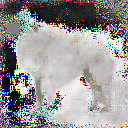

In [14]:
# visualize one generated image
gen_img_list =os.listdir("../gen_images/")
temp_img = load_img("../gen_images/"+gen_img_list[1000])
temp_img

In [15]:
def combine_images(generated_images):
    total = generated_images.shape[0]
    cols = int(math.sqrt(total))
    rows = math.ceil(float(total)/cols)
    width, height, ch= generated_images.shape[1:]
    output_shape = (
        height * rows,
        width * cols,
        ch
    )
    combined_image = np.zeros(output_shape)

    for index, image in enumerate(generated_images):
        i = int(index/cols)
        j = index % cols
        combined_image[width*i:width*(i+1), height*j:height*(j+1)] = image[:, :, :]
    return combined_image

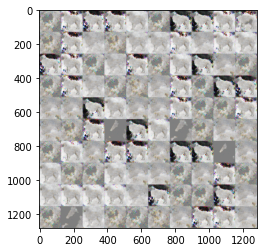

In [16]:
# visualize multiple generated images
combined_image = combine_images(generated_images_v[:100])
plt.imshow(combined_image.astype(np.uint8))

In [17]:
import shutil
shutil.make_archive('images', 'zip', '../gen_images/')



'/kaggle/working/images.zip'